In [147]:
import pandas as pd
import datetime
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from bokeh import plotting
# for hover tooltip
from bokeh.models import HoverTool
font = {'size'   : 18}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
input_folder = "../samples"

In [135]:
time_format = "%Y-%m-%dT%H:%M:%SZ"
news_data = pd.read_csv(os.path.join(input_folder, "nyt_bitcoin.csv"), names=['time', 'headline'],
                        index_col=0, parse_dates=[0], 
                        date_parser=lambda x: datetime.datetime.strptime(x, time_format)) \
            .drop_duplicates(take_last=True) \
            .iloc[::-1] # reverse the original order of index
news_data.head()

,headline
time,
2013-05-06 19:24:31,A Push for a Bitcoin Buttonwood
2013-04-12 16:30:37,Adam Smith Hates Bitcoin
2013-04-12 15:55:16,Week in Review: From Banes of Zuckerberg to Bi...
2013-04-11 17:20:13,TimesCast: Bitcoin Has Real-World Investors
2013-04-11 16:42:24,Bitcoin Has Real-World Investors


In [136]:
news_index = news_data[:]
news_index.loc[:,'price'] = None
news_index.drop('headline', axis=1, inplace=True)
news_index.loc[:,'bit'] = 1
news_index.head()

,price,bit
time,,
2013-05-06 19:24:31,None,1
2013-04-12 16:30:37,None,1
2013-04-12 15:55:16,None,1
2013-04-11 17:20:13,None,1
2013-04-11 16:42:24,None,1


In [76]:
time_format = "%Y-%m-%dT%H:%M:%S"
price_data = pd.read_csv(os.path.join(input_folder, "price.csv"), names=['time', 'price'], 
                   index_col='time', parse_dates=[0], 
                   date_parser=lambda x: datetime.datetime.strptime(x, time_format))
price_data['time_index'] = price_data.index
price_data.drop_duplicates(subset='time_index', take_last=True, inplace=True)
del price_data['time_index']
price_data.head()

,price
time,
2013-05-24 19:47:05,132.90
2013-05-24 19:36:56,132.43
2013-05-24 19:26:49,133.20
2013-05-24 19:16:57,133.58
2013-05-24 19:06:47,133.88


In [145]:
news_filled = pd.concat([news_index, price_data]).sort_index()
# news_filled.loc[:,'price'].fillna(method='ffill', inplace=True)
news_filled.loc[:,'price'].interpolate(method='time', inplace=True)
news_filled.dropna(axis=0, inplace=True)
news_filled.drop('bit', axis=1, inplace=True)
news_price = pd.merge(news_filled, news_data, how='left', left_index=True, right_index=True)
news_price.head()

,price,headline
time,,
2012-01-16 01:01:41,6.972100,"'Good Wife' Watch: Jason Biggs, Jim Cramer and..."
2012-04-12 14:30:13,4.854307,Canada Seeks to Turn Coins Into Digital Currency
2013-03-12 20:28:27,45.560234,Today's Scuttlebot: Bitcoin Problem and Tracki...
2013-04-08 00:00:00,163.849333,"Bubble or No, This Virtual Currency Is a Lot o..."
2013-04-11 16:42:24,121.746388,Bitcoin Has Real-World Investors



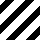
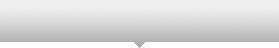
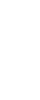
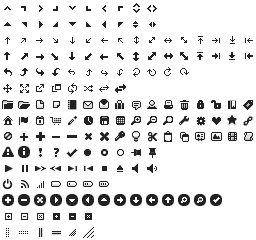
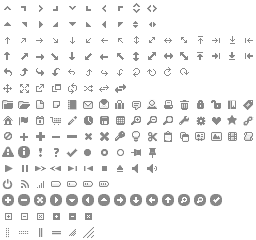
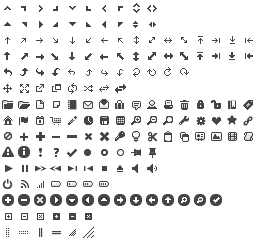
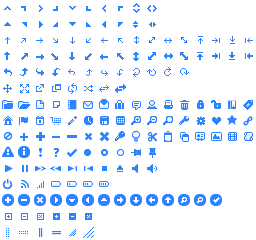
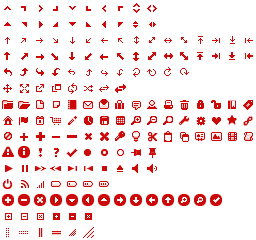
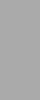
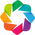
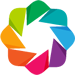
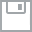
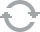
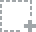
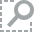
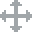
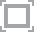
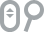

In [158]:
# Create a set of tools to use
TOOLS="pan,wheel_zoom,box_zoom,reset,hover"

# We need to put these data into a ColumnDataSource
tip_source = plotting.ColumnDataSource(
    data=dict(
        x=news_price.index,
        y=news_price['price'],
        headline=news_price.loc[:,'headline']
    )
)

plotting.output_notebook()
# create a figure
p1 = plotting.figure(title="Test",
                    x_axis_label="Date",
                    y_axis_label="Price",
                    x_axis_type="datetime",
                    plot_width=1000, plot_height=400,
                    tools=TOOLS)
p1.below[0].formatter.formats = dict(years=['%Y'], months=['%b %Y'], days=['%d %b %Y'])
# make plot
## price line plot
p1.line(
    price_data.index, price_data['price'],
#     color='#A6CEE3',
    legend='BTC Price')
## news headline scatter plot
p1.circle(news_price.index, news_price['price'], 
          source=tip_source,
          legend="News", 
          fill_color="red", 
          size=8)
# hover tooltip
hover = p1.select(dict(type=HoverTool))
hover.tooltips = [("price", "$y"),
                  ("headline", "@headline")
                 ]

plotting.show(p1)